# Assignment2 (Regression)_투빅스 14기 이혜린

위 데이터는 Used Car Price in **India** 이다. (인도화폐단위 : Rs. 루피)

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

## 데이터 정제

In [62]:
dat = pd.read_csv("assignment2_train-data.csv")
dat.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [63]:
del dat['Unnamed: 0']
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


* `Mileage`, `Engine`, `Power`, `New_Price` 변수는 단위 제거 후 숫자형 변수로 바꿀 필요가 있다.  
* `Mileage`, `Engine`, `Power`, `Seats`, `New_Price` 변수는 결측치가 존재한다.
* `New_Price` 변수는 단위가 Lakh(=십만). Cr(=천만) 두 개이므로 하나로 통일할 필요가 있다. → Lakh(=십만)으로 통일

In [64]:
# 단위 제거 후 숫자형 변수로 변경

dat['Mileage'] = dat['Mileage'].str.replace(" km/kg","")
dat['Mileage'] = dat['Mileage'].str.replace(" kmpl","")
dat['Engine'] = dat['Engine'].str.replace(" CC","")

dat['Power'] = dat['Power'].str.replace(" bhp","")
dat['Power'] = dat['Power'].apply(lambda x: None if x=="null" else x)
dat['Power'] = dat['Power'].apply(lambda x: None if x=="" else x)

dat['New_Price'] = dat['New_Price'].str.replace(" Lakh","")
dat.loc[dat['New_Price'].str.contains('Cr')==True,'New_Price'] = pd.to_numeric(dat[dat['New_Price'].str.contains('Cr')==True]['New_Price'].str.replace(' Cr','')) * 100

dat['Mileage'] = pd.to_numeric(dat['Mileage'])
dat['Engine'] = pd.to_numeric(dat['Engine'])
dat['Power'] = pd.to_numeric(dat['Power'])
dat['New_Price'] = pd.to_numeric(dat['New_Price'])

* `Name` 변수를 통해 `Company` 회사명 변수를 생성한다.

In [65]:
dat['Company'] = dat.Name.str.split().str[0]

In [66]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    float64
 12  Price              6019 non-null   float64
 13  Company            6019 non-null   object 
dtypes: float64(6), int64(2), object(6)
memory usage: 658.5+ KB


Variable | Type | Unique | Explanation
:-|:-|:-|:-
Name | object | 1876 | 차종
Location | object | 11 | 자동차가 판매된 또는 살 수 있는 위치
Year | num | | 자동차 출시 년도
Kilometers_Driven | num | | 주행거리(km)
Fuel_Type | object | 5 | 연료 타입
Transmission | object | 2 | 변속기 (수동, 자동)
Owner_Type | object | 4 | 첫 차, 두번째 차, ...
Mileage | num | | kmpl : 내연기관차 연비, km/kg : 수소차 연비. 단위는 달라도 비교 가능 → 단위 제거
Engine | num | | 배기량(=엔진 내부의 실린더 크기). 차의 성능을 나타내는 지표 중 하나. 높다고 해서 무조건 좋은 건 아님.
Power | num | | 브레이크 마력
Seats | num | | 인승
New_price | num | | 자동차 원가(단위 : Lakh). 원데이터는 단위가 Lakh(=십만),Cr(=천만) 두개 였으나 하나로 통일.
Price | num | | 자동차 중고가(단위 : Lakh)  
Company | object | 31 | 자동차 회사명
  
  
   unique의 개수가 적당한 범주형 변수는 `Fuel_Type`, `Transmission`, `Owner_Type`, `Company` 이다.

## 결측치 처리  
  
`Mileage`, `Engine`, `Power`, `Seats` 변수는 자동차의 가격을 결정하는 중요 변수가 될 가능성이 있으므로 결측치를 잘 다뤄야 한다.

In [67]:
dat[dat['Mileage'].isnull()==True]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company
4446,Mahindra E Verito D4,Chennai,2016,50000,Electric,Automatic,First,NaN,72.0,41.0,5.0,13.58,13.00,Mahindra
4904,Toyota Prius 2009-2016 Z4,Mumbai,2011,44000,Electric,Automatic,First,NaN,1798.0,73.0,5.0,NaN,12.75,Toyota


In [68]:
dat[dat['Engine'].isnull()==True]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company
194,Honda City 1.5 GXI,Ahmedabad,2007,60006,Petrol,Manual,First,0.00,NaN,NaN,NaN,NaN,2.95,Honda
208,Maruti Swift 1.3 VXi,Kolkata,2010,42001,Petrol,Manual,First,16.10,NaN,NaN,NaN,NaN,2.11,Maruti
733,Maruti Swift 1.3 VXi,Chennai,2006,97800,Petrol,Manual,Third,16.10,NaN,NaN,NaN,NaN,1.75,Maruti
749,Land Rover Range Rover 3.0 D,Mumbai,2008,55001,Diesel,Automatic,Second,0.00,NaN,NaN,NaN,NaN,26.50,Land
1294,Honda City 1.3 DX,Delhi,2009,55005,Petrol,Manual,First,12.80,NaN,NaN,NaN,NaN,3.20,Honda
1327,Maruti Swift 1.3 ZXI,Hyderabad,2015,50295,Petrol,Manual,First,16.10,NaN,NaN,NaN,NaN,5.80,Maruti
1385,Honda City 1.5 GXI,Pune,2004,115000,Petrol,Manual,Second,0.00,NaN,NaN,NaN,NaN,1.50,Honda
1460,Land Rover Range Rover Sport 2005 2012 Sport,Coimbatore,2008,69078,Petrol,Manual,First,0.00,NaN,NaN,NaN,NaN,40.88,Land
2074,Maruti Swift 1.3 LXI,Pune,2011,24255,Petrol,Manual,First,16.10,NaN,NaN,NaN,NaN,3.15,Maruti
2096,Hyundai Santro LP zipPlus,Coimbatore,2004,52146,Petrol,Manual,First,0.00,NaN,NaN,NaN,NaN,1.93,Hyundai


`Engine` 값이 NA인 데이터는 `Power`, `Seats` 값도 NA이다. 세 변수 모두 값이 없는 데이터는 분석에 사용하기 어렵다고 판단되므로 obs를 제거한다.

In [69]:
dat = dat.dropna(axis=0, subset=['Engine'])

In [70]:
dat[dat['Power'].isnull()==True]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company
76,Ford Fiesta 1.4 SXi TDCi,Jaipur,2008,111111,Diesel,Manual,First,17.80,1399.0,NaN,5.0,NaN,2.00,Ford
79,Hyundai Santro Xing XL,Hyderabad,2005,87591,Petrol,Manual,First,0.00,1086.0,NaN,5.0,NaN,1.30,Hyundai
89,Hyundai Santro Xing XO,Hyderabad,2007,73745,Petrol,Manual,First,17.00,1086.0,NaN,5.0,NaN,2.10,Hyundai
120,Hyundai Santro Xing XL eRLX Euro III,Mumbai,2005,102000,Petrol,Manual,Second,17.00,1086.0,NaN,5.0,NaN,0.85,Hyundai
143,Hyundai Santro Xing XO eRLX Euro II,Kochi,2008,80759,Petrol,Manual,Third,17.00,1086.0,NaN,5.0,NaN,1.67,Hyundai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5873,Hyundai Santro Xing XO eRLX Euro II,Pune,2006,47200,Petrol,Manual,Second,17.00,1086.0,NaN,5.0,NaN,1.20,Hyundai
5893,Maruti Estilo LXI,Chennai,2008,51000,Petrol,Manual,Second,19.50,1061.0,NaN,NaN,NaN,1.75,Maruti
5925,Skoda Laura Classic 1.8 TSI,Pune,2010,85000,Petrol,Manual,First,17.50,1798.0,NaN,5.0,NaN,2.85,Skoda
5943,Mahindra Jeep MM 540 DP,Chennai,2002,75000,Diesel,Manual,First,0.00,2112.0,NaN,6.0,NaN,1.70,Mahindra


In [71]:
dat[dat['Seats'].isnull()==True]

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company
229,Ford Figo Diesel,Bangalore,2015,70436,Diesel,Manual,First,0.0,1498.0,99.0,NaN,NaN,3.60,Ford
1917,Honda City 1.5 EXI,Jaipur,2005,88000,Petrol,Manual,Second,13.0,1493.0,100.0,NaN,NaN,1.70,Honda
2369,Maruti Estilo LXI,Chennai,2008,56000,Petrol,Manual,Second,19.5,1061.0,NaN,NaN,NaN,1.50,Maruti
3800,Ford Endeavour Hurricane LE,Mumbai,2012,129000,Diesel,Automatic,First,12.8,2953.0,NaN,NaN,NaN,7.00,Ford
3882,Maruti Estilo LXI,Kolkata,2010,40000,Petrol,Manual,Second,19.5,1061.0,NaN,NaN,NaN,2.50,Maruti
5893,Maruti Estilo LXI,Chennai,2008,51000,Petrol,Manual,Second,19.5,1061.0,NaN,NaN,NaN,1.75,Maruti


`Mileage`, `Power`, `Engine`, `New_Price` 변수의 결측치는 회사별 평균값으로 대체한다.

In [72]:
fill_mean_func = lambda x: x.fillna(x.mean())
dat = dat.groupby('Company').apply(fill_mean_func)

In [73]:
dat.loc[dat['Power'].isnull(),'Power'] = dat['Power'].mean() #회사별 obs가 1개인 관측치는 전체 데이터셋의 평균값으로 대체

In [74]:
dat.loc[dat['New_Price'].isnull(),'New_Price'] = dat['New_Price'].mean() 
#회사별 평균 New_Price 값이 없는 관측치는 전체 데이터셋의 평균값으로 대체

In [75]:
print(dat.isnull().sum())

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
New_Price            0
Price                0
Company              0
dtype: int64


In [76]:
dat.reset_index(drop=True, inplace=True) #인덱스 재정렬
dat.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Price
count,5983.000000,5.983000e+03,5983.000000,5983.000000,5983.000000,5983.000000,5983.000000,5983.000000
mean,2013.383085,5.868418e+04,18.174107,1621.276450,113.045536,5.278627,22.102991,9.496263
std,3.249102,9.150334e+04,4.526457,601.355233,53.676433,0.808443,23.409131,11.200462
min,1998.000000,1.710000e+02,0.000000,72.000000,34.200000,0.000000,3.910000,0.440000
25%,2011.000000,3.396550e+04,15.200000,1198.000000,75.000000,5.000000,9.221860,3.500000
50%,2014.000000,5.300000e+04,18.160000,1493.000000,94.000000,5.000000,11.624896,5.650000
75%,2016.000000,7.300000e+04,21.100000,1984.000000,138.100000,5.000000,23.872073,9.950000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,10.000000,230.000000,160.000000


Independent Variable들의 평균 및 분산이 굉장히 많이 차이 나기 때문에 scaling이 필요해 보인다.  

## 연속형 변수 (Scaling)  
  
StandardScaler를 통해 Z-score scaling을 진행한다.

In [80]:
from sklearn.preprocessing import StandardScaler

num_att_x = ['Year', 'Kilometers_Driven','Mileage','Engine','Power','Seats','New_Price']
scaler = StandardScaler()
dat_num_scaled = pd.DataFrame(scaler.fit_transform(dat[num_att_x]),columns=num_att_x)
dat_num_scaled

dat_extra = dat.drop(num_att_x, axis=1)
dat = pd.concat([dat_num_scaled,dat_extra],axis=1)

In [81]:
dat.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Name,Location,Fuel_Type,Transmission,Owner_Type,Price,Company
0,-3.195945,0.232971,-1.187365,-0.219982,-1.444806,-0.344675,-8.651394e-14,Ambassador Classic Nova Diesel,Chennai,Diesel,Manual,Third,1.35,Ambassador
1,-0.117915,-0.196886,-0.657105,0.576618,0.517113,-0.344675,1.948011e+00,Audi A4 New 2.0 TDI Multitronic,Coimbatore,Diesel,Automatic,Second,17.74,Audi
2,0.497691,-0.029501,-1.026077,0.603227,1.191767,-0.344675,1.948011e+00,Audi A6 2011-2015 35 TFSI Technology,Mumbai,Petrol,Automatic,First,23.50,Audi
3,-1.041324,-0.258856,-1.275742,1.790645,1.238160,-0.344675,1.948011e+00,Audi A6 2.7 TDI,Kolkata,Diesel,Automatic,First,11.50,Audi
4,0.497691,-0.492222,-0.235106,0.576618,1.141834,-0.344675,1.948011e+00,Audi A4 2.0 TDI 177 Bhp Premium Plus,Kochi,Diesel,Automatic,First,21.43,Audi


## Target Variable (=Response Variable)

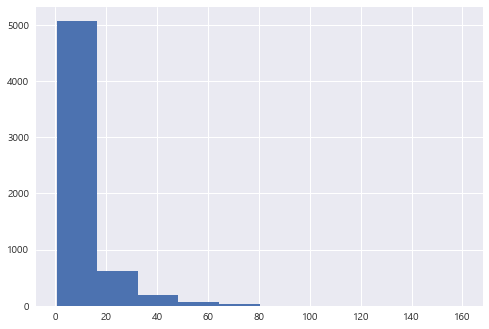

In [82]:
dat['Price'].hist()

In [83]:
dat['Price'].sort_values().tail()

325      93.67
2739     97.07
2705    100.00
2722    120.00
2757    160.00
Name: Price, dtype: float64

Target Variable `Price`의 분포를 그려본 결과, 왼쪽으로 치우쳐져 있음을 알 수 있다.  
→ 분포 가정 중 하나인 **오차의 정규성**을 확보하기 위해 **Transformation** 필요  
→ **log transformation** 실시

In [84]:
dat['log_price'] = np.log(dat['Price'])

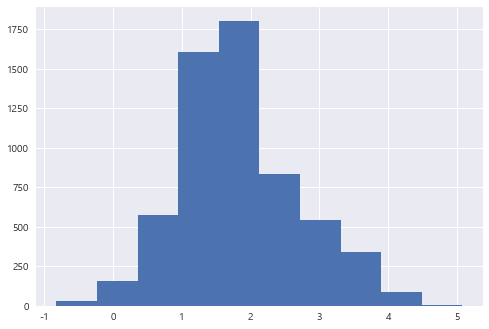

In [85]:
dat['log_price'].hist()

**오차의 정규성** 만족  
### Target Variable = `log_price`

In [86]:
dat = dat.drop(['Price'], axis=1) #Price 변수 제거

## 범주형 변수  
  
unique의 개수가 적당한 `Fuel_Type`, `Transmission`, `Owner_Type` 을 중점적으로 살펴본다.  
위 변수들의 더미변수를 생성하고 데이터셋에 추가한다.

In [87]:
fuel_d = pd.get_dummies(dat['Fuel_Type'], prefix='fuel', drop_first=True)
trans_d = pd.get_dummies(dat['Transmission'], prefix='trans', drop_first=True)
owner_d = pd.get_dummies(dat['Owner_Type'], prefix='owner', drop_first=True)
dat = pd.concat([dat,fuel_d,trans_d,owner_d],axis=1)
dat = dat.drop(['Name','Location','Fuel_Type', 'Transmission', 'Owner_Type'], axis=1)

In [88]:
dat.head()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,Company,log_price,fuel_Diesel,fuel_Electric,fuel_LPG,fuel_Petrol,trans_Manual,owner_Fourth & Above,owner_Second,owner_Third
0,-3.195945,0.232971,-1.187365,-0.219982,-1.444806,-0.344675,-8.651394e-14,Ambassador,0.300105,1,0,0,0,1,0,0,1
1,-0.117915,-0.196886,-0.657105,0.576618,0.517113,-0.344675,1.948011e+00,Audi,2.875822,1,0,0,0,0,0,1,0
2,0.497691,-0.029501,-1.026077,0.603227,1.191767,-0.344675,1.948011e+00,Audi,3.157000,0,0,0,1,0,0,0,0
3,-1.041324,-0.258856,-1.275742,1.790645,1.238160,-0.344675,1.948011e+00,Audi,2.442347,1,0,0,0,0,0,0,0
4,0.497691,-0.492222,-0.235106,0.576618,1.141834,-0.344675,1.948011e+00,Audi,3.064792,1,0,0,0,0,0,0,0


## Correlation 확인  
  
범주형 변수(및 dummy variable)는 연속형 변수와의 Pearson correlation coefficient를 계산해서 판단을 내리면 안된다.  
그러므로 연속형 변수들간의 상관계수를 파악한다.

In [89]:
num_att = ['Year', 'Kilometers_Driven','Mileage','Engine','Power','Seats','New_Price','log_price']
dat[num_att].corr()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,New_Price,log_price
Year,1.000000,-0.172546,0.313535,-0.052197,0.021696,0.012543,0.003924,0.504586
Kilometers_Driven,-0.172546,1.000000,-0.065158,0.091068,0.032044,0.083098,0.008120,-0.047192
Mileage,0.313535,-0.065158,1.000000,-0.597048,-0.507168,-0.307552,-0.390821,-0.265031
Engine,-0.052197,0.091068,-0.597048,1.000000,0.863920,0.393156,0.628524,0.686766
Power,0.021696,0.032044,-0.507168,0.863920,1.000000,0.094851,0.754003,0.762245
Seats,0.012543,0.083098,-0.307552,0.393156,0.094851,1.000000,-0.050077,0.163758
New_Price,0.003924,0.008120,-0.390821,0.628524,0.754003,-0.050077,1.000000,0.688188
log_price,0.504586,-0.047192,-0.265031,0.686766,0.762245,0.163758,0.688188,1.000000


* target 변수인 `log_price`와의 상관관계가 매우 약해보이는 `Kilometers_Driven`을 제외한 나머지 변수는 모두 회귀분석에 사용한다.  
**→ 독립변수와 종속변수 간 선형성 만족** 
* `Power` 변수와 `Engine` 변수, `Power` 변수와 `New_Price` 변수의 상관관계가 매우 높아보인다. → 다중공선성 의심 → VIF 검정 실시

In [90]:
dat = dat.drop(['Kilometers_Driven'],axis=1) # target 변수와 상관관계가 약한 변수 제거

In [91]:
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF 검정 실시

num_att1 = ['Year', 'Mileage','Engine','Power','Seats','New_Price']
X1_num = dat[num_att1]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X1_num.values, i) for i in range(X1_num.shape[1])]
vif["features"] = X1_num.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
2,6.890270,Engine
3,6.821621,Power
5,2.419930,New_Price
1,1.829704,Mileage
4,1.774768,Seats
0,1.203011,Year


VIF 결과, 다행히 다중공선성 문제가 심각해보이는 변수는 없는 것으로 보인다.

## Linear Regression  
  
unique가 31인 `Company` 변수를 제외한 나머지 범주형 변수들로 만든 더미변수들과 숫자형 변수들을 이용해서 회귀분석을 진행한다.

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [110]:
dat = dat.drop(['Company'], axis=1)

In [111]:
dat.shape

(5983, 15)

In [112]:
X1 = dat.drop(['log_price'],axis=1)
y = dat['log_price']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=0)
model1 = LinearRegression()
model1.fit(X_train, y_train)
pred1 = model1.predict(X_train)
model1.score(X_train, y_train) #R-squared

0.8957804512625962

In [115]:
mean_squared_error(y_train, pred1) #MSE

0.07905626289117157

In [116]:
print(model1.coef_) # 추정된 회귀계수 (intercept제외)
print(model1.intercept_) # intercept

[ 0.41498291 -0.04707817  0.0972218   0.30489846  0.03677199  0.19268816
  0.23962309  1.13571229  0.1160692  -0.0074398  -0.21895082  0.09189222
 -0.06020816 -0.09833113]
1.8716851052242551


In [117]:
# test data R-squared
model1.score(X_test, y_test)

0.8729647903540595

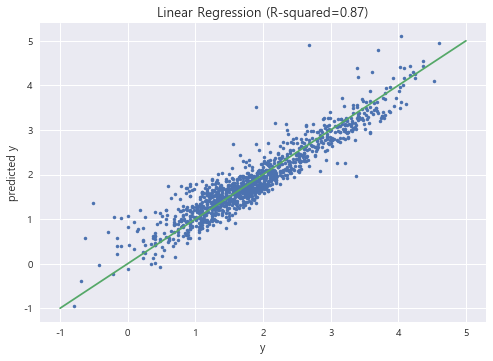

In [124]:
plt.plot(y_test, model1.predict(X_test), '.') # 예측 vs 실제 데이터 plot

x = np.linspace(-1, 5, 100)
y = x
plt.plot(x, y)
plt.xlabel('y')
plt.ylabel('predicted y')
plt.title('Linear Regression (R-squared=0.87)', fontsize=13)
plt.show()

obs가 직선 상에 꽤 분포해있는 것으로 보아 Linear Regression 결과는 꽤 타당하다.  
다중공선성 문제가 있어보이진 않으나 추가적으로 **Ridge Regression**과 **Lasso Regression**을 실행한다.

## Ridge Regression

In [120]:
dat.shape

(5983, 15)

In [121]:
X2 = dat.drop(['log_price'], axis=1)
y = dat['log_price']
X2.shape

(5983, 14)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=0)
model2 = Ridge(alpha=0.05) #alpha = hyperparameter (지정해줘야 하는 값)
model2.fit(X_train, y_train)
pred2 = model2.predict(X_train)
model2.score(X_train,y_train) #R-squared

0.8957796075854552

In [123]:
mean_squared_error(y_train, pred2) #MSE

0.07905690286671035

In [125]:
print(model2.coef_) #추정된 회귀계수 (intercept 제외)
print(model2.intercept_) #intercept

[ 0.41497893 -0.04712464  0.09728669  0.30479992  0.03674278  0.1926822
  0.23779633  1.07968752  0.11359828 -0.00928673 -0.21903213  0.09117604
 -0.06023492 -0.09833122]
1.8735813193578097


In [126]:
# test data R-squared
model2.score(X_test,y_test)

0.8729747505721539

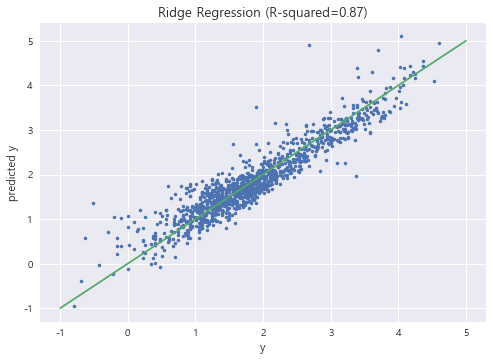

In [128]:
plt.plot(y_test, model2.predict(X_test), '.') # 예측 vs 실제 데이터 plot

x = np.linspace(-1, 5, 100)
y = x
plt.plot(x, y)
plt.xlabel('y')
plt.ylabel('predicted y')
plt.title('Ridge Regression (R-squared=0.87)', fontsize=13)
plt.show()

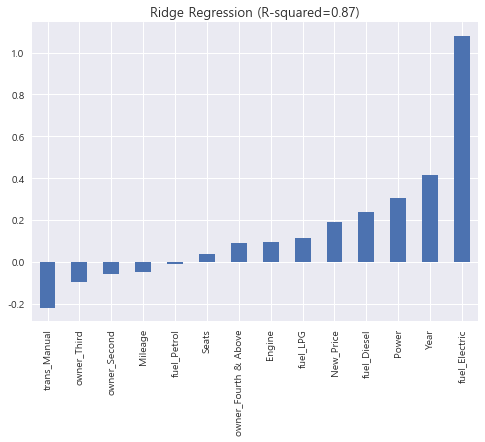

In [129]:
coef_ridge = pd.Series(model2.coef_, X_train.columns).sort_values()
coef_ridge.plot(kind='bar')
plt.title('Ridge Regression (R-squared=0.87)', fontsize=13)
plt.show()

### Key Point  
  
* Linear Regression과 Ridge Regression의 결과가 같다. (회귀계수, R-squared, MSE)
* Linear Regression에서 Z-score normalization 후 모든 숫자형 독립변수에 대한 다중공선성 문제가 해결되었기 때문이라고 생각해볼 수 있다.
* 보통 Ridge Regression의 alpha값이 커질수록 회귀계수의 크기는 줄어드는 데, 이 때 alpha값을 적절하게 조절하여 R-squared 가 가장 커지는 alpha값을 채택해야 한다.

## Lasso Regression

In [130]:
dat.shape

(5983, 15)

In [131]:
X3 = dat.drop(['log_price'], axis=1)
y = dat['log_price']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=0)
model3 = Lasso(alpha=0.05)
model3.fit(X_train, y_train)
pred3 = model3.predict(X_train)
model3.score(X_train,y_train)

0.8692324326018008

In [133]:
mean_squared_error(y_train, pred3) #MSE

0.09919439597574049

In [134]:
print(model3.coef_) #추정된 회귀계수 (intercept 제외)
print(model3.intercept_) #intercept

[ 0.3904519  -0.          0.20055433  0.27593638  0.          0.21465469
  0.00971974  0.         -0.         -0.         -0.          0.
 -0.         -0.        ]
1.824042750191525


In [135]:
# test data R-squared
model3.score(X_test,y_test)

0.8500109923713499

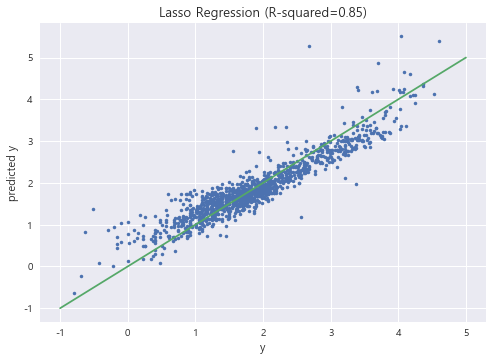

In [136]:
plt.plot(y_test, model3.predict(X_test), '.') # 예측 vs 실제 데이터 plot

x = np.linspace(-1, 5, 100)
y = x
plt.plot(x, y)
plt.xlabel('y')
plt.ylabel('predicted y')
plt.title('Lasso Regression (R-squared=0.85)', fontsize=13)
plt.show()

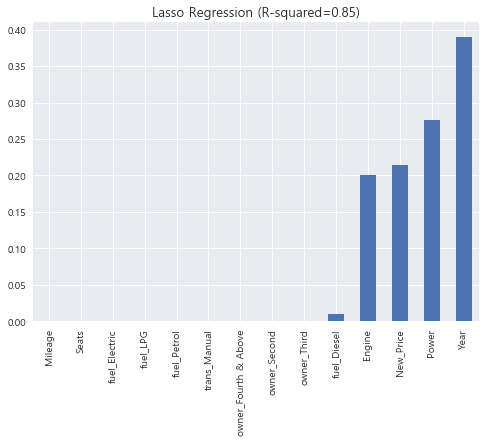

In [137]:
coef_lasso = pd.Series(model3.coef_, X_train.columns).sort_values()
coef_lasso.plot(kind='bar')
plt.title('Lasso Regression (R-squared=0.85)', fontsize=13)
plt.show()

### Key Point  
  
* Lasso Regression을 사용한 결과, Linear Regression과 Ridge Regression에 비해 R-squared가 약간 **감소**하고 MSE가 약간 **증가**했다.  
* Lasso Regression의 경우, Ridge Regression에 비해 **회귀계수의 크기가 작다**. 
즉 **Ridge Regression 보다 더 많은 parameter를 축소시켜, 중요변수를 더 확실하게 가려낼 수 있다.**  
* Lasso Regression의 alpha값이 커질수록 회귀계수의 크기는 줄어드는 데, 이 때의 alpha값을 적절하게 조절하여 R-squared 가 가장 커지는 alpha값을 채택해야 한다.

## ElasticNet  
  
Ridge와 Lasso를 절충한 모델.  
보통 선형회귀 보다는 Ridge 회귀를 쓰는 것이 좋다. (약간의 규제가 있는 것이 대부분의 경우에 좋음)  
Ridge 회귀가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 생각되면 라쏘나 엘라스틱을 사용하는데, 이 때 특성의 개수가 train set 개수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 Lasso 보다는 ElasticNet을 사용하는 것이 좋다.  
  
이 데이터셋의 경우, 특성의 개수가 train set 개수보다 많지는 않기 때문에 그냥 Lasso를 사용해도 괜찮을 것이라고 판단된다.

## statsmodel OLS

In [140]:
import statsmodels.api as sm

In [138]:
X1 = dat.drop(['log_price'],axis=1)
y = dat['log_price']
y.shape

(5983,)

In [142]:
model4 = sm.OLS(y, X1)
result4 = model4.fit()
print(result4.summary())

                                 OLS Regression Results                                
Dep. Variable:              log_price   R-squared (uncentered):                   0.972
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                          1.495e+04
Date:                Sat, 01 Aug 2020   Prob (F-statistic):                        0.00
Time:                        21:58:51   Log-Likelihood:                         -1987.0
No. Observations:                5983   AIC:                                      4002.
Df Residuals:                    5969   BIC:                                      4096.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

p-value를 관찰해보면 모델에 쓰인 모든 설명변수가 타당하다는 것을 볼 수 있다.

## 회귀분석 가정 검토

In [143]:
import scipy.stats

### 설명변수와 종속변수 간 선형성 

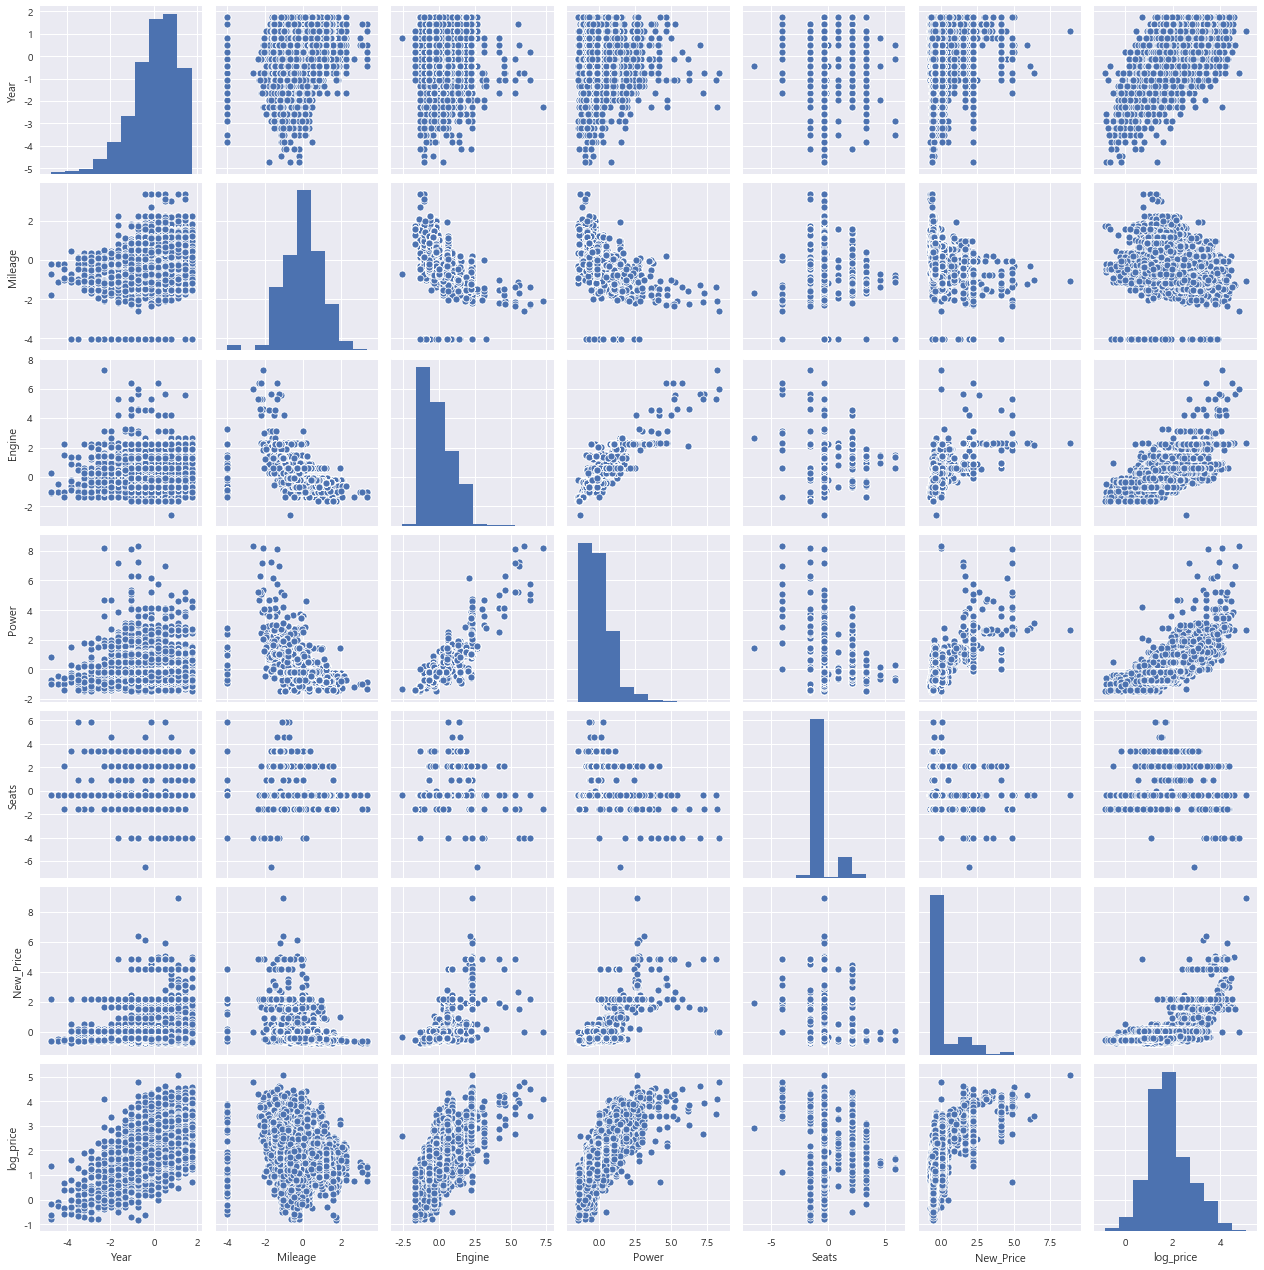

In [162]:
num_att_full = ['Year', 'Mileage','Engine','Power','Seats','New_Price','log_price']
sns.pairplot(dat[num_att_full])

correlation plot에서도 확인했지만 최종 모델의 설명변수와 종속변수 `log_price` 간 선형관계는 충분히 존재함을 알 수 있다.

### 잔차의 정규성 검토

In [149]:
pred = result4.predict()
residual = dat['log_price'] - pred
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)

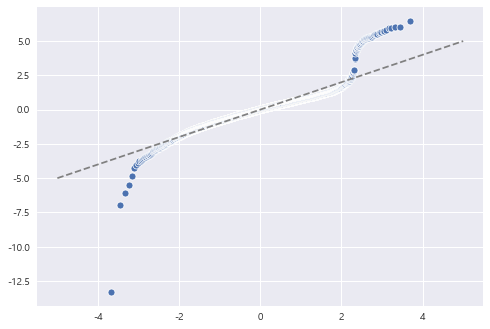

In [154]:
sns.scatterplot(x, y)
plt.plot([-5, 5], [-5, 5], '--', color='grey')

정규성 가정을 만족하는 편이다.  
  
### 잔차의 등분산성 검토

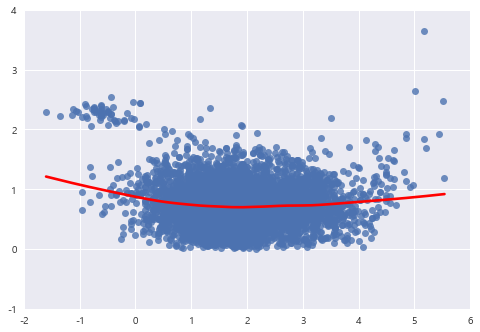

In [159]:
sns.regplot(pred, np.sqrt(np.abs(sr)), lowess=True, line_kws={'color': 'red'})
plt.xlim(-2,6)
plt.ylim(-1,4)
plt.show()

이상적인 케이스의 경우, red line이 직선이여야 하지만 실제 데이터에서 그런 경우를 찾는 것은 어렵다.  
자료가 고르게 분포해 있는 것으로 보아 등분산성을 어느 정도 만족한다고 볼 수 있다.

### 설명변수 간 독립성  
  
VIF 검정을 통해 설명변수 간 다중공선성 가능성이 없음을 확인했다.

## 결론  
  
* Dependent Variable : `log_price`  
* List of Independent Variable (Z-score normalized) : `Year`, `Mileage`,`Engine`,`Power`,`Seats`,`New_Price`, `Fuel_Type`, `Transmission`, `Owner_Type`
  
  
  
  
Model | Explanation | R-squared | MSE
:-|:-|:-|:-
Linear | 리스트에 있는 모든 독립변수 사용. Ridge와 결과 같음. | 0.87 | 0.08
Ridge | Linear와 결과 같음 | 0.87 | 0.08
Lasso | 독립변수 `fuel_Diesel`, `Engine`, `New_Price`, `Power`, `Year` 를 제외한 나머지 변수 탈락 | 0.85 | 0.1
  
  
  
  
* Linear Regression을 했을 때 Multicollinearity 문제가 있다면 Ridge Estimator를 활용하는 것이 하나의 방법이겠으나,  
이 경우에는 Multicollinearity 가능성을 Z-score normalization을 통해 해결했기 때문에 Linear와 Ridge의 결과가 같은 것으로 추정된다.  
그래도 대부분의 경우 약간의 규제가 있는 것이 좋으므로 Linear Regression 보다는 Ridge Regression을 이용하면 좋을 것 같다.
  
  
* Lasso Regression을 이용하면 모델 성능이 아주 조금 낮아진다.  
  
  
* 설명변수와 종속변수간 선형성, 잔차의 정규성, 잔차의 등분산성, 설명변수간 독립성 모두 만족